In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter


In [3]:
# specify GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
# reproducibility
RANDOM_STATE = 0
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



## Data Loading

In [5]:
DIR = os.getcwd()
if DIR.endswith("code"):
    DIR = DIR[:-5]
SAVED_IN = os.path.abspath(DIR + "/models" + "/NN_tuned_complex_concat")
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)
print(f"saved in: {SAVED_IN}")

from utils.plot_util import plot_one_gt_train_test, plot_gt_pre_overlap, plot_3_losses
from utils.data_util import (
    dotdict,
    extract_pos_s21_offset,
    load_pos_s21,
    save_pre,
    load_pre,
    PreprocessedDataset,
    get_dataloader,
)
from utils.nn_util import train_NN, count_parameters
from utils.complex_util import dict_act_complex, complex_normalize, NN_complex_concat

saved in: c:\Users\xinch\Desktop\RBI\models\CNN_complex_fe


## Data Extraction

In [6]:
# load data
folder = os.path.join(DIR, "data")
data_file_name = os.path.join(folder, "data_offset_complex.pkl")
pos, s21, pos_TEST, s21_TEST = load_pos_s21(data_file_name, 5)

X = s21
Y = pos

X_TEST = s21_TEST
y_TEST = pos_TEST


## Data Preprocessing

### Train test split wit indicies

In [7]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, indices, test_size=0.2, random_state=RANDOM_STATE
)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(411257, 121)
(411257,)
(102815, 121)
(102815,)


### Normalization

In [8]:
X_train_scaled, X_train_mean, X_train_std = complex_normalize(X_train)
X_test_scaled, X_test_mean, X_test_std = complex_normalize(X_test, X_train_mean, X_train_std)
X_TEST_scaled, X_TEST_mean, X_TEST_std = complex_normalize(X_TEST, X_train_mean, X_train_std)

X_scaled = np.zeros_like(X)
X_scaled[idx_train] = X_train_scaled
X_scaled[idx_test] = X_test_scaled

y_train = Y[idx_train].reshape(-1, 1)  # reshape to (N,1)
y_test = Y[idx_test].reshape(-1, 1)  # reshape to (N,1)
y_TEST = y_TEST.reshape(-1, 1)  # reshape to (N,1)

print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)
print(X_TEST_scaled.shape)
print(y_TEST.shape)


(411257, 121)
(411257, 1)
(102815, 121)
(102815, 1)
(20135, 121)
(20135, 1)


# NN

## 32-16

### Init

In [13]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 4e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":True, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexBatchNorm1d()
    (2): ComplexSigmoid()
    (3): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (4): ComplexBatchNorm1d()
    (5): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)
number of learning parameters: 9137


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [15]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [16]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [17]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1033.02, test loss : 986.12, TEST loss : 981.23, lr: 0.0010
epoch : 10, train loss : 315.46, test loss : 288.12, TEST loss : 284.51, lr: 0.0010
epoch : 20, train loss : 16.62, test loss : 13.33, TEST loss : 12.17, lr: 0.0010
epoch : 30, train loss : 10.82, test loss : 8.37, TEST loss : 7.56, lr: 0.0010
epoch : 40, train loss : 8.22, test loss : 5.73, TEST loss : 5.40, lr: 0.0010
epoch : 50, train loss : 7.04, test loss : 4.50, TEST loss : 4.58, lr: 0.0010
epoch : 60, train loss : 6.10, test loss : 3.71, TEST loss : 3.80, lr: 0.0010
epoch : 70, train loss : 5.59, test loss : 4.78, TEST loss : 4.87, lr: 0.0010
epoch : 80, train loss : 5.28, test loss : 3.28, TEST loss : 3.52, lr: 0.0010
epoch : 90, train loss : 5.08, test loss : 2.70, TEST loss : 3.03, lr: 0.0010
epoch : 100, train loss : 4.91, test loss : 2.64, TEST loss : 3.04, lr: 0.0010
epoch : 110, train loss : 4.68, test loss : 2.74, TEST loss : 3.04, lr: 0.0010
epoch : 120, train loss : 4.59, test loss : 2.

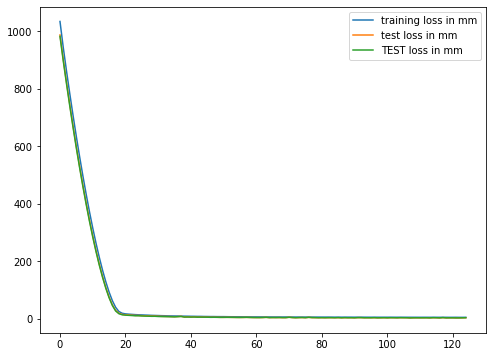

In [18]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [19]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexBatchNorm1d()
    (2): ComplexSigmoid()
    (3): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (4): ComplexBatchNorm1d()
    (5): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [20]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.36 mm
test RMSE: 2.37 mm
TEST RMSE: 2.67 mm


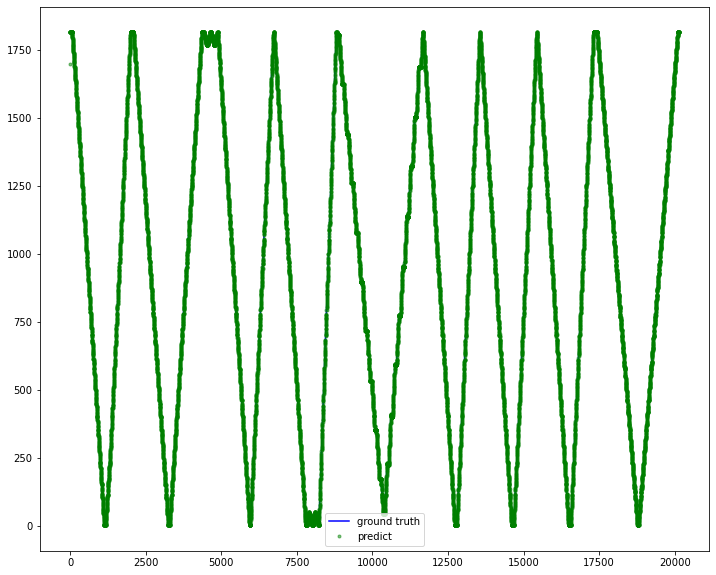

In [21]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


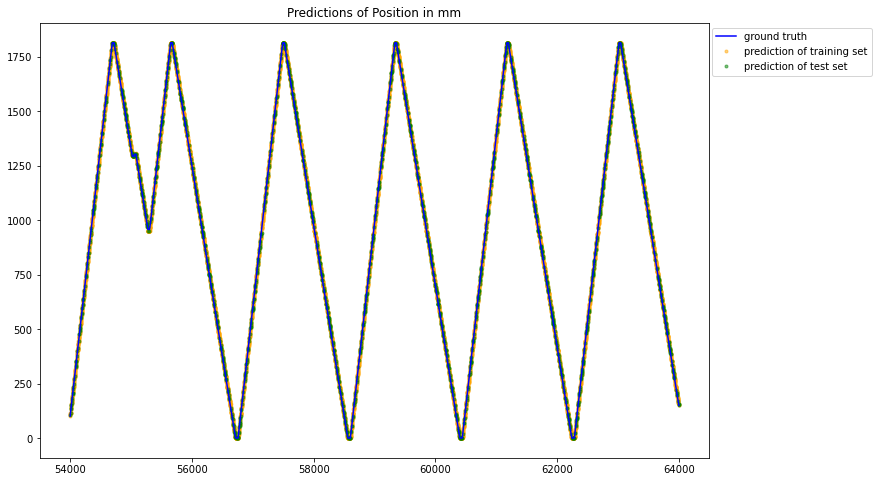

In [22]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 32-16 no bn bs64

### Init

In [14]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 64,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 4e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)
number of learning parameters: 8897


In [15]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [16]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [17]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [18]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1014.56, test loss : 946.93, TEST loss : 941.99, lr: 0.0010
epoch : 10, train loss : 61.02, test loss : 38.11, TEST loss : 36.71, lr: 0.0010
epoch : 20, train loss : 2.65, test loss : 2.56, TEST loss : 4.23, lr: 0.0010
epoch : 30, train loss : 2.05, test loss : 1.81, TEST loss : 2.97, lr: 0.0010
epoch : 40, train loss : 1.76, test loss : 1.85, TEST loss : 3.00, lr: 0.0010
epoch : 50, train loss : 1.59, test loss : 1.70, TEST loss : 3.19, lr: 0.0010
epoch : 60, train loss : 1.47, test loss : 1.59, TEST loss : 3.32, lr: 0.0010
epoch : 70, train loss : 1.39, test loss : 1.84, TEST loss : 3.54, lr: 0.0010
epoch : 80, train loss : 1.33, test loss : 1.23, TEST loss : 3.10, lr: 0.0010
epoch : 90, train loss : 1.29, test loss : 1.22, TEST loss : 3.21, lr: 0.0010
epoch : 100, train loss : 1.24, test loss : 1.38, TEST loss : 3.24, lr: 0.0010
epoch : 110, train loss : 1.20, test loss : 1.15, TEST loss : 3.34, lr: 0.0010
epoch : 120, train loss : 1.15, test loss : 1.05, TES

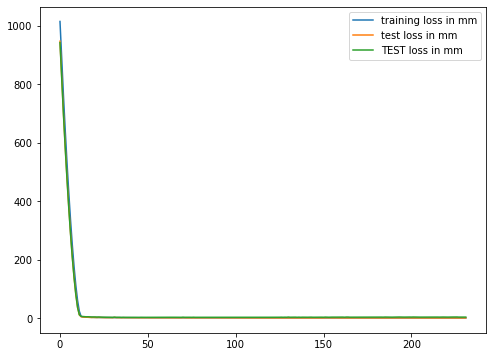

In [19]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [20]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.83 mm
test RMSE: 0.84 mm
TEST RMSE: 3.92 mm


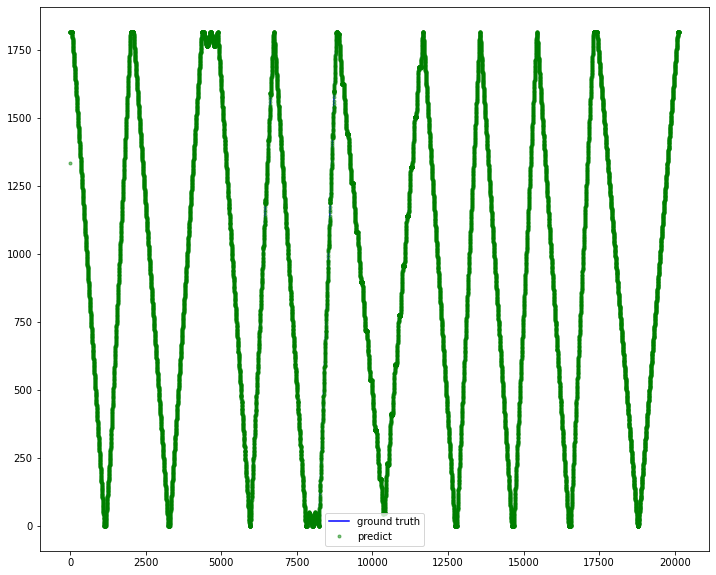

In [22]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


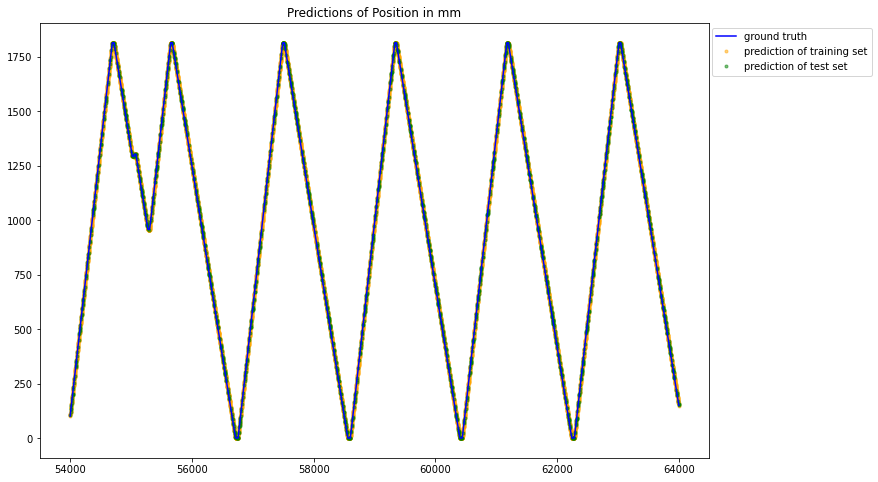

In [23]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## 32-16 no bn

### Init

In [24]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 16],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 4e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-16.pth
NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)
number of learning parameters: 8897


In [25]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [26]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [27]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [28]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1045.90, test loss : 1015.90, TEST loss : 1010.95, lr: 0.0010
epoch : 10, train loss : 437.97, test loss : 412.60, TEST loss : 408.55, lr: 0.0010
epoch : 20, train loss : 53.29, test loss : 41.55, TEST loss : 39.95, lr: 0.0010
epoch : 30, train loss : 2.74, test loss : 2.66, TEST loss : 3.65, lr: 0.0010
epoch : 40, train loss : 2.09, test loss : 1.91, TEST loss : 2.90, lr: 0.0010
epoch : 50, train loss : 1.81, test loss : 1.60, TEST loss : 2.42, lr: 0.0010
epoch : 60, train loss : 1.63, test loss : 1.45, TEST loss : 2.33, lr: 0.0010
epoch : 70, train loss : 1.51, test loss : 1.41, TEST loss : 2.20, lr: 0.0010
epoch : 80, train loss : 1.43, test loss : 1.51, TEST loss : 2.25, lr: 0.0010
epoch : 90, train loss : 1.36, test loss : 1.43, TEST loss : 2.23, lr: 0.0010
epoch : 100, train loss : 1.28, test loss : 1.42, TEST loss : 2.15, lr: 0.0010
epoch : 110, train loss : 1.23, test loss : 1.22, TEST loss : 2.02, lr: 0.0010
epoch : 120, train loss : 1.18, test loss : 1

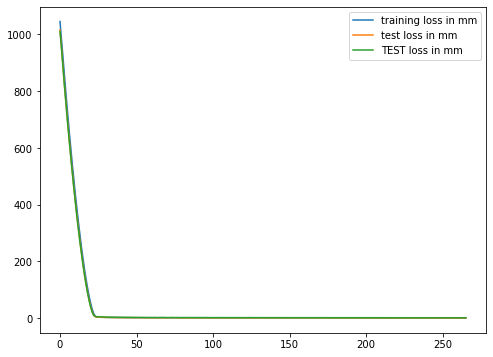

In [29]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [30]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=16, bias=True)
      (fc_i): Linear(in_features=32, out_features=16, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 0.74 mm
test RMSE: 0.75 mm
TEST RMSE: 1.53 mm


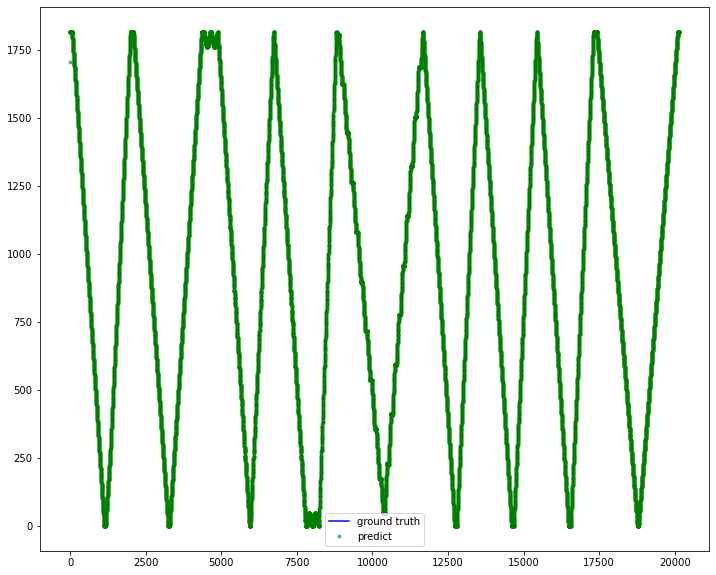

In [32]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


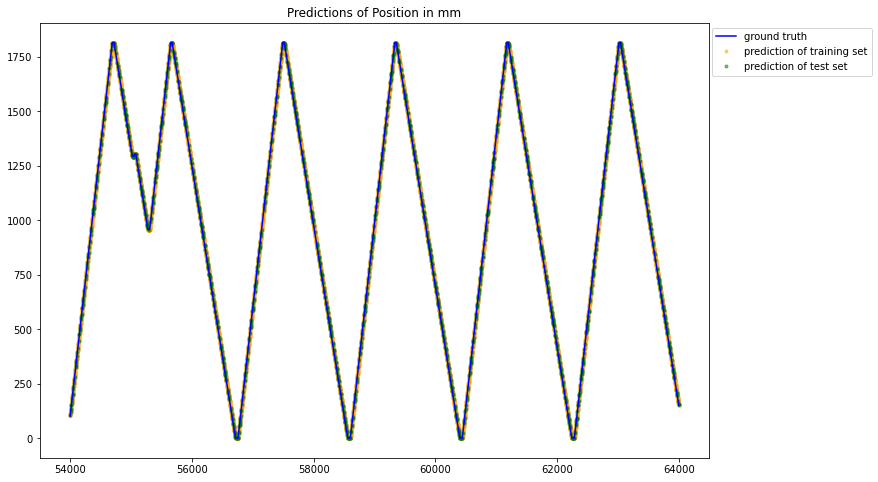

In [33]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## With 32-8

### Init

In [13]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 8],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 4e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":True, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-8.pth
NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexBatchNorm1d()
    (2): ComplexSigmoid()
    (3): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (4): ComplexBatchNorm1d()
    (5): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)
number of learning parameters: 8553


In [14]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [15]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [16]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [17]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1055.33, test loss : 1031.01, TEST loss : 1026.16, lr: 0.0010
epoch : 10, train loss : 637.23, test loss : 619.17, TEST loss : 614.54, lr: 0.0010
epoch : 20, train loss : 305.68, test loss : 291.54, TEST loss : 287.85, lr: 0.0010
epoch : 30, train loss : 78.23, test loss : 69.49, TEST loss : 66.59, lr: 0.0010
epoch : 40, train loss : 22.25, test loss : 19.85, TEST loss : 17.40, lr: 0.0010
epoch : 50, train loss : 15.08, test loss : 13.01, TEST loss : 11.15, lr: 0.0010
epoch : 60, train loss : 10.72, test loss : 8.33, TEST loss : 7.34, lr: 0.0010
epoch : 70, train loss : 8.34, test loss : 6.29, TEST loss : 6.17, lr: 0.0010
epoch : 80, train loss : 7.09, test loss : 5.21, TEST loss : 5.56, lr: 0.0010
epoch : 90, train loss : 6.57, test loss : 4.76, TEST loss : 5.46, lr: 0.0010
epoch : 100, train loss : 6.12, test loss : 5.52, TEST loss : 6.65, lr: 0.0010
epoch : 110, train loss : 5.84, test loss : 3.64, TEST loss : 5.43, lr: 0.0010
epoch : 120, train loss : 5.60, 

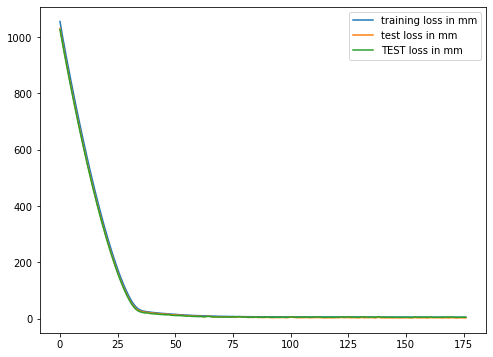

In [18]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [19]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexBatchNorm1d()
    (2): ComplexSigmoid()
    (3): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (4): ComplexBatchNorm1d()
    (5): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [20]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 2.42 mm
test RMSE: 2.42 mm
TEST RMSE: 5.60 mm


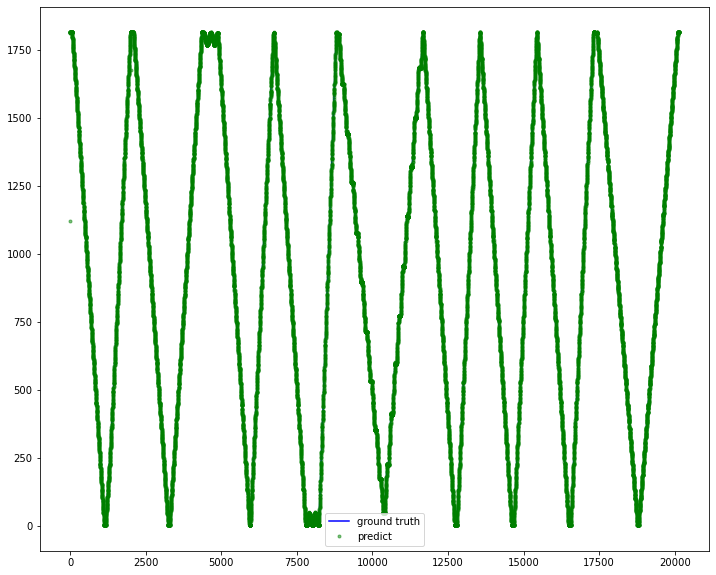

In [21]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


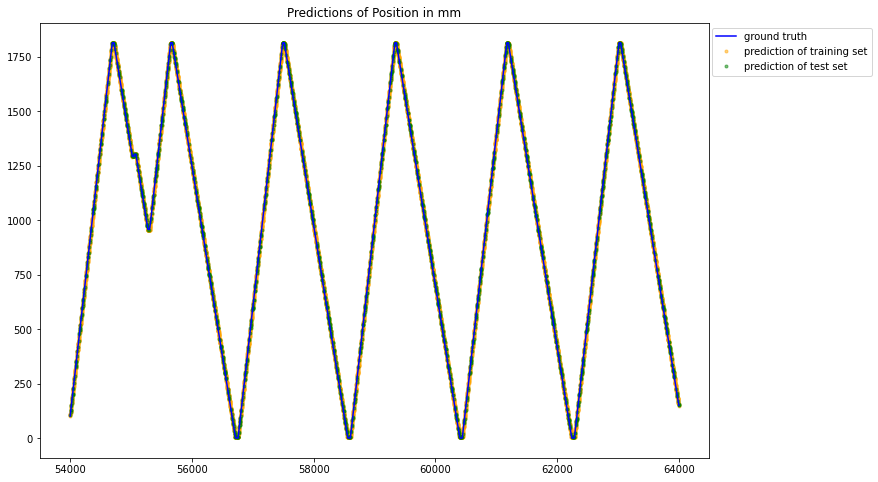

In [22]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)


## With 32-8 no bn

### Init

In [23]:
# configuration
_config = {
    "n_features": 121,
    "list_hidden": [32, 8],
    "activation": "sigmoid",
    "batch_size": 128,
    "epochs": 500,
    "decay_after": 100,
    "patience": 16,  # terminate after "patience" iterations without improvement
    "lr": 0.001,  # default value
    "weight_decay": 4e-4,
    "betas": (0.9, 0.999),  # default value
    "use_dropout":False, 
    "use_bn":False, 
}

# dot access
config = dotdict(_config)

## define the model
MODEL_NAME = "NN_" + "-".join(map(str, config.list_hidden)) + ".pth"
model = NN_complex_concat(
    n_features=config.n_features,
    list_hidden=config.list_hidden,
    activation_fn=dict_act_complex[config.activation],
    use_dropout=config.use_dropout,
    use_bn=config.use_bn,
)
print(MODEL_NAME)
print(model)
print(f"number of learning parameters: {count_parameters(model)}")


NN_32-8.pth
NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)
number of learning parameters: 8353


In [24]:
# save config
config_save_path = os.path.join(SAVED_IN, MODEL_NAME).replace("pth", "config")
with open(config_save_path, "wb") as f:
    pickle.dump(_config, f, pickle.HIGHEST_PROTOCOL)


In [25]:
## Initialize the NN
def weights_init(m):
    """Function for initializing all model weights"""
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)


## define the optimizer and scheduler
def lr_lambda(epoch, epochs=config.epochs, decay_after=config.decay_after):
    """Function for scheduling learning"""
    return (
        1.0
        if epoch < decay_after
        else 1 - float(epoch - decay_after) / (epochs - decay_after)
    )


model.to(device).apply(weights_init)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.lr,
    betas=config.betas,
    weight_decay=config.weight_decay,
) 
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()


In [26]:
## define the Dataloaders
train_dataloader = get_dataloader(
    is_train=True, batch_size=config.batch_size, x=X_train_scaled, y=y_train
)
test_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_test_scaled, y=y_test
)
TEST_dataloader = get_dataloader(
    is_train=False, batch_size=2048, x=X_TEST_scaled, y=y_TEST
)


### Training

In [27]:
best_loss, best_epoch, train_losses, test_losses, TEST_losses = train_NN(
    model,
    config,
    loss_fn,
    optimizer,
    scheduler,
    train_dataloader,
    test_dataloader,
    TEST_dataloader,
    device,
    SAVED_IN,
    MODEL_NAME,
    writer=SummaryWriter(),
)


  0%|          | 0/500 [00:00<?, ?it/s]

epoch : 0, train loss : 1060.31, test loss : 1044.82, TEST loss : 1039.93, lr: 0.0010
epoch : 10, train loss : 757.55, test loss : 744.26, TEST loss : 739.43, lr: 0.0010
epoch : 20, train loss : 492.05, test loss : 479.38, TEST loss : 475.10, lr: 0.0010
epoch : 30, train loss : 257.70, test loss : 247.49, TEST loss : 244.11, lr: 0.0010
epoch : 40, train loss : 83.76, test loss : 76.67, TEST loss : 74.39, lr: 0.0010
epoch : 50, train loss : 3.83, test loss : 3.37, TEST loss : 4.12, lr: 0.0010
epoch : 60, train loss : 2.68, test loss : 2.33, TEST loss : 3.11, lr: 0.0010
epoch : 70, train loss : 2.27, test loss : 2.11, TEST loss : 2.74, lr: 0.0010
epoch : 80, train loss : 2.00, test loss : 1.78, TEST loss : 2.44, lr: 0.0010
epoch : 90, train loss : 1.80, test loss : 1.77, TEST loss : 2.18, lr: 0.0010
epoch : 100, train loss : 1.69, test loss : 1.61, TEST loss : 2.06, lr: 0.0010
epoch : 110, train loss : 1.60, test loss : 1.58, TEST loss : 2.00, lr: 0.0010
epoch : 120, train loss : 1.51, t

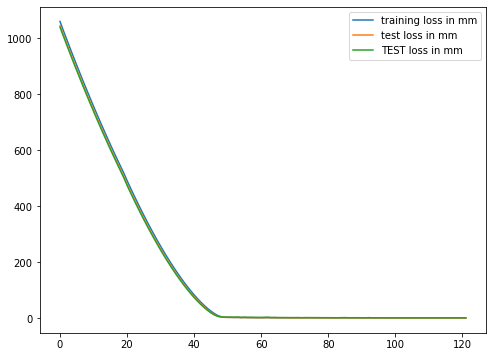

In [28]:
plot_3_losses(train_losses, test_losses, TEST_losses)


### Evaluation

In [29]:
model.load_state_dict(torch.load(os.path.join(SAVED_IN, MODEL_NAME), map_location=device))
model.to(device)
model.eval()


NN_complex_concat(
  (activation): ComplexSigmoid()
  (layers): Sequential(
    (0): ComplexLinear(
      (fc_r): Linear(in_features=121, out_features=32, bias=True)
      (fc_i): Linear(in_features=121, out_features=32, bias=True)
    )
    (1): ComplexSigmoid()
    (2): ComplexLinear(
      (fc_r): Linear(in_features=32, out_features=8, bias=True)
      (fc_i): Linear(in_features=32, out_features=8, bias=True)
    )
    (3): ComplexSigmoid()
  )
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [30]:
# evaluation on  training, test and TEST set

with torch.no_grad():
    y_ = model(torch.from_numpy(X_scaled).to(device)).cpu().numpy().squeeze()
    y_TEST_ = model(torch.from_numpy(X_TEST_scaled).to(device)).cpu().numpy().squeeze()
y_train_ = y_[idx_train]
y_test_ = y_[idx_test]

RMSE_test_final_mm = np.sqrt(mean_squared_error(y_test, y_test_))
RMSE_train_final_mm = np.sqrt(mean_squared_error(y_train, y_train_))
RMSE_TEST_final_mm = np.sqrt(mean_squared_error(y_TEST, y_TEST_))

print(f"train RMSE: {RMSE_train_final_mm:.2f} mm")
print(f"test RMSE: {RMSE_test_final_mm:.2f} mm")
print(f"TEST RMSE: {RMSE_TEST_final_mm:.2f} mm")


train RMSE: 1.41 mm
test RMSE: 1.43 mm
TEST RMSE: 1.92 mm


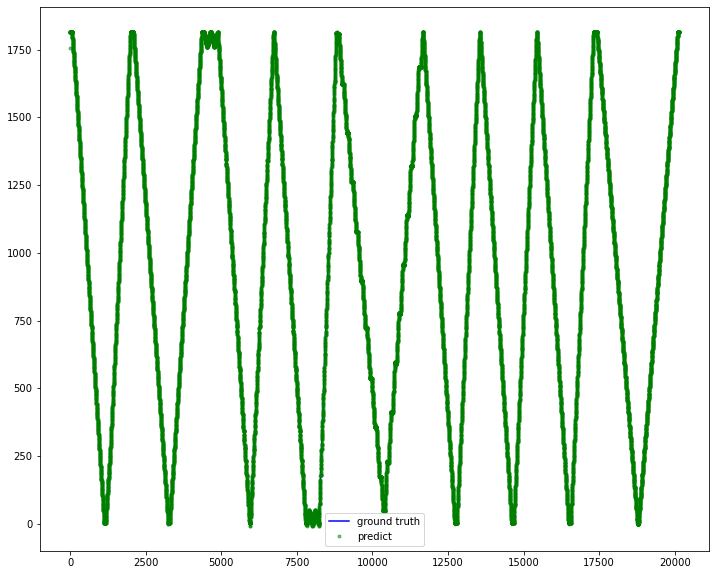

In [31]:
plot_gt_pre_overlap(y_TEST, y_TEST_)


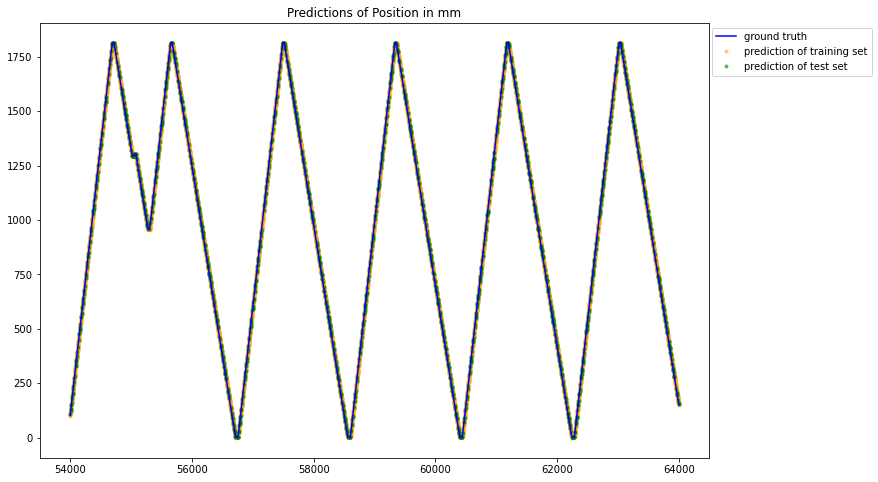

In [32]:
F = 54000
L = F + 10000
plot_one_gt_train_test(
    Y, y_, idx_train_sort, idx_test_sort, F, L, "Predictions of Position in mm"
)
